# DATA DIRI
- Nama: Muhammad Shodiq Fathoni
- Email: shodiqfathoni3@gmail.com
- Id Dicoding: shodiq29

## project prediksi menggunakan dataset konsumsi energi biomassa untuk pembangkit listrik di romania

In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/data project/electricityConsumptionAndProductioction.csv')
df.tail()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
36767,2023-03-12 19:00:00,6500,6643,1407,111,3084,933,1047,0,60
36768,2023-03-12 20:00:00,6471,6484,1408,58,2983,933,1042,0,60
36769,2023-03-12 21:00:00,6194,6413,1406,39,2938,935,1031,0,62
36770,2023-03-12 22:00:00,5708,6217,1406,8,2823,917,1001,0,61
36771,2023-03-12 23:00:00,5409,5900,1403,0,2492,914,1030,0,60


In [6]:
df.isnull().sum()

DateTime         0
Consumption      0
Production       0
Nuclear          0
Wind             0
Hydroelectric    0
Oil and Gas      0
Coal             0
Solar            0
Biomass          0
dtype: int64

In [7]:
date = df['DateTime'].values
bio = df[['Biomass']].values

In [8]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
bio = min_max_scaler.fit_transform(bio.reshape(-1, 1)).flatten()

In [9]:
# calculate threshold MAE
threshold_mae = (bio.max() - bio.min()) * 10/100
print(threshold_mae)

0.1


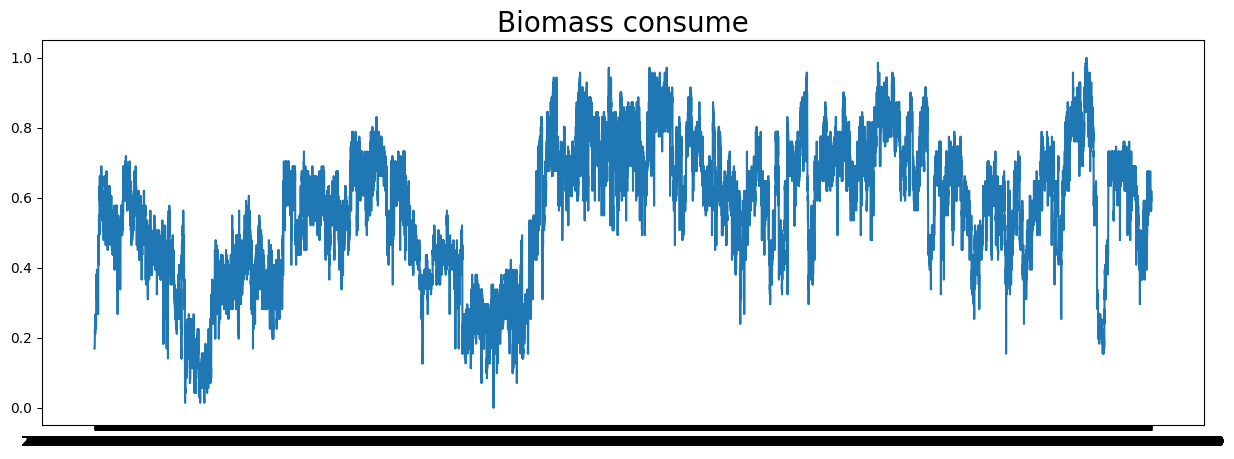

In [10]:
plt.figure(figsize=(15,5))
plt.plot(date, bio)
plt.title('Biomass consume',
          fontsize=20);

In [11]:
from sklearn.model_selection import train_test_split
date_latih, date_test, bio_latih, bio_test = train_test_split(date,bio, test_size=0.2, shuffle=False)

In [12]:
print(bio_latih.shape)
print(bio_test.shape)

(29417,)
(7355,)


In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
train_set = windowed_dataset(bio_latih, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(bio_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.10):
      print("\nmae telah mencapai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100,validation_data=test_set,verbose=1,callbacks=[callbacks])

Epoch 1/100
294/294 [==============================] - 24s 45ms/step - loss: 0.0972 - mae: 0.4102 - val_loss: 0.0441 - val_mae: 0.2696
Epoch 2/100
294/294 [==============================] - 10s 35ms/step - loss: 0.0263 - mae: 0.1957 - val_loss: 0.0135 - val_mae: 0.1359
Epoch 3/100
294/294 [==============================] - 11s 36ms/step - loss: 0.0148 - mae: 0.1450 - val_loss: 0.0085 - val_mae: 0.1042
Epoch 4/100
294/294 [==============================] - 13s 44ms/step - loss: 0.0135 - mae: 0.1372 - val_loss: 0.0077 - val_mae: 0.0975
Epoch 5/100
294/294 [==============================] - 12s 40ms/step - loss: 0.0132 - mae: 0.1350 - val_loss: 0.0075 - val_mae: 0.0951
Epoch 6/100
294/294 [==============================] - 11s 36ms/step - loss: 0.0129 - mae: 0.1331 - val_loss: 0.0072 - val_mae: 0.0936
Epoch 7/100
294/294 [==============================] - 12s 39ms/step - loss: 0.0125 - mae: 0.1310 - val_loss: 0.0070 - val_mae: 0.0922
Epoch 8/100
294/294 [==============================] - 

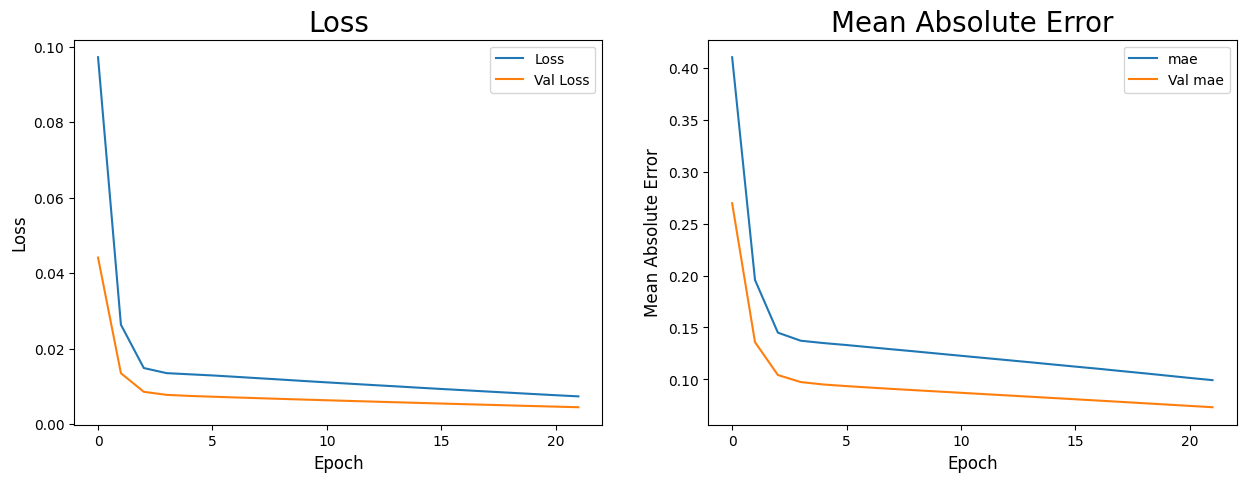

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()